### Import the required modules

In [2]:
import os
import math
import numpy as np
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from bayes_opt import BayesianOptimization

# Keras modules
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import to_categorical
from keras.models import Sequential
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense

/home/poc/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Pre-process the Dataset

In [3]:


# Load the datasets
sample_full_data = loadmat('Digit_Dataset_Full.mat')
label_train_data = pd.read_csv("Digit_Dataset_Full_Train_Labels.csv")
label_test_data = pd.read_csv("Digit_Dataset_Full_Test_Labels.csv")

# Get data from the datasets
X_train_orig = sample_full_data['Image'][0, 0][0]
X_test_orig = sample_full_data['Image'][0, 0][1]
Y_train_orig = label_train_data.values[:, 0]
Y_test_orig = label_test_data.values[:, 0]

# Print details of the orignal data
print("X_train_orig shape: " + str(X_train_orig.shape))
print("X_test_orig shape: " + str(X_test_orig.shape))
print("Y_train_orig shape: " + str(Y_train_orig.shape))
print("Y_test_orig shape: " + str(Y_test_orig.shape), "\n")

# Reshape the input data for keras
split_fraction = 0.9     # should be greater than 0.5
train_set_len = math.ceil((X_train_orig.shape[3] + X_test_orig.shape[3]) * split_fraction)
test_set_len = X_train_orig.shape[3] + X_test_orig.shape[3] - train_set_len
X_train = np.zeros((train_set_len, X_train_orig.shape[0], X_train_orig.shape[1], X_train_orig.shape[2]))
X_test = np.zeros((test_set_len, X_train_orig.shape[0], X_train_orig.shape[1], X_train_orig.shape[2]))
Y_train = np.zeros((train_set_len, 1))
Y_test = np.zeros((test_set_len, 1))

# Split into train and test, by the given split fraction
for i in range(train_set_len + test_set_len):
    if i < train_set_len:
        if i < X_train_orig.shape[3]:
            X_train[i] = X_train_orig[:, :, :, i]
            Y_train[i] = Y_train_orig[i]
        else:
            X_train[i] = X_test_orig[:, :, :, i - X_train_orig.shape[3]]
            Y_train[i] = Y_test_orig[i - X_train_orig.shape[3]]
        
    else:
        if i < X_train_orig.shape[3]:
            X_test[i - train_set_len] = X_train_orig[:, :, :, i]
            Y_test[i - train_set_len] = Y_train_orig[i]
        else:
            X_test[i - train_set_len] = X_test_orig[:, :, :, i - X_train_orig.shape[3]]
            Y_test[i - train_set_len] = Y_test_orig[i - X_train_orig.shape[3]]

# Convert the integer labels into one-hot
Y_train = to_categorical(Y_train, num_classes=10, dtype='float32')
Y_test = to_categorical(Y_test, num_classes=10, dtype='float32')

# Print details of the reshaped data
print("X_train shape: " + str(X_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_train shape: " + str(Y_train.shape))
print("Y_test shape: " + str(Y_test.shape))

# Create an image generator class
imgGentrain = ImageDataGenerator()
imgGentest = ImageDataGenerator()

train_batch = imgGentrain.flow(
    x=X_train,
    y=Y_train,
    batch_size=32,
    shuffle=True,
    seed=1)
test_batch = imgGentest.flow(
    x=X_test,
    y=Y_test,
    batch_size=32,
    shuffle=True,
    seed=2)

X_train_orig shape: (28, 28, 1, 9000)
X_test_orig shape: (28, 28, 1, 1000)
Y_train_orig shape: (9000,)
Y_test_orig shape: (1000,) 

X_train shape: (9000, 28, 28, 1)
X_test shape: (1000, 28, 28, 1)
Y_train shape: (9000, 10)
Y_test shape: (1000, 10)


### Example of an Image

y = [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


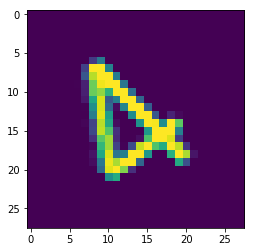

In [4]:
index = 3600    # just some image for preview
plt.imshow(X_train[index, :, :, 0])
print("y = " + str(np.squeeze(Y_train[index, :])))

### 1.1 - Create a Model (With Batch Normalization)

In [5]:
def create_model(lr=0.001, beta_1=0.9):
    try:
        del model
    except:
        pass

    # Create a model
    model = Sequential()

    # Add a convolutional layer
    model.add(Conv2D(filters=32, kernel_size=5, strides=(1, 1), padding='valid', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

    # 2. Add a convolution layer
    model.add(Conv2D(filters=16, kernel_size=3, strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    # Flatten the output
    model.add(Flatten())

    # Add a dense layer
    model.add(Dense(10))
    model.add(Activation('softmax'))
    optAdam = optimizers.Adam(lr=lr, beta_1=beta_1, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer=optAdam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

### Function to Evaluate the Current Model

In [6]:
def fit_with(lr=0.001, beta_1=0.9):
    # Create the model using a specified hyperparameters.
    model = create_model(lr=lr, beta_1=beta_1)
    
    # Train the model with the train dataset.
    model.fit_generator(
        generator=train_batch,
        steps_per_epoch=len(train_batch),
        epochs=3)
    
    # print the test accuracy
    score = model.evaluate(X_test, Y_test, verbose = 0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    # return the test accuracy
    return score[1]

fit_with_partial = partial(fit_with)

### 1.2 - Bayesian Optimization

In [7]:
# Bounded region of parameter space
pbounds = {'lr': (1e-4, 1e-2), 'beta_1': (0.8, 1)}

# Create the bayesian optimizer
optimizer = BayesianOptimization(
    f=fit_with_partial,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

# Maximize the accuracy
optimizer.maximize(init_points=10, n_iter=10,)

# Print the result
for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

print(optimizer.max)

|   iter    |  target   |  beta_1   |    lr     |
-------------------------------------------------
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
282/282 [==============================] - 21s 74ms/step - loss: 3.6921 - acc: 0.6659
Epoch 2/3
282/282 [==============================] - 18s 62ms/step - loss: 3.2720 - acc: 0.7848
Epoch 3/3
282/282 [==============================] - 17s 61ms/step - loss: 2.3819 - acc: 0.8241
Test loss: 0.09564479201845824
Test accuracy: 0.971
|  1        |  0.971    |  0.8834   |  0.007231 |
Epoch 1/3
282/282 [==============================] - 18s 64ms/step - loss: 0.5866 - acc: 0.8183
Epoch 2/3
282/282 [==============================] - 22s 78ms/step - loss: 0.0882 - acc: 0.9709
Epoch 3/3
282/282 [==============================] - 24s 86ms/step - loss: 0.0131 - acc: 0.9977
Test loss: 0.006796402305364609
Test accuracy: 0.998
|  2        |  0.998    |  0.8      |  0.003093 |

Epoch 1/3
282/282 [==============================] - 20s 72ms/step - loss: 1.7040 - acc: 0.4383
Epoch 2/3
282/282 [==============================] - 19s 66ms/step - loss: 0.8624 - acc: 0.7502
Epoch 3/3
282/282 [==============================] - 18s 64ms/step - loss: 0.5462 - acc: 0.8610
Test loss: 0.4608350868225098
Test accuracy: 0.878
|  19       |  0.878    |  0.9335   |  0.0001   |
Epoch 1/3
282/282 [==============================] - 20s 72ms/step - loss: 1.5992 - acc: 0.4848
Epoch 2/3
282/282 [==============================] - 18s 65ms/step - loss: 0.8468 - acc: 0.7564
Epoch 3/3
282/282 [==============================] - 18s 63ms/step - loss: 0.5337 - acc: 0.8681
Test loss: 0.4637343616485596
Test accuracy: 0.88
|  20       |  0.88     |  0.9763   |  0.0001   |
Iteration 0: 
	{'target': 0.971, 'params': {'beta_1': 0.8834044009405149, 'lr': 0.007231212485077366}}
Iteration 1: 
	{'target': 0.998, 'params': {'beta_1': 0.800022874963469, 'lr': 0.003093092469055214}}
Iteration 2: 
	{'t

### 1.3 - Perform Grid Search

In [8]:
lr_list = np.array([10**-5, 10**-4, 10**-3])
mom_list = np.array([0.8, 0.9, 1.0])

g_grid = np.meshgrid(lr_list, mom_list)
g_grid_points = np.append(g_grid[0].reshape(-1,1), g_grid[1].reshape(-1,1), axis=1)

g_result_list = []
for i in g_grid_points:
    model = create_model(lr=i[0], beta_1=i[1])
    model.fit_generator(
        generator=train_batch,
        steps_per_epoch=len(train_batch),
        epochs=5)
    score = model.evaluate(X_test, Y_test, verbose = 0)
    g_result_list.append([i[0], i[1], score[0], score[1]])

for i in g_result_list:
    print("For learning rate = {0} and momentum = {1}: loss = {2}, accuracy = {3}".format(i[0], i[1], i[2], i[3]))

Epoch 1/5
282/282 [==============================] - 22s 77ms/step - loss: 2.4378 - acc: 0.1541
Epoch 2/5
282/282 [==============================] - 18s 63ms/step - loss: 2.1100 - acc: 0.2493
Epoch 3/5
282/282 [==============================] - 19s 68ms/step - loss: 1.8855 - acc: 0.3478
Epoch 4/5
282/282 [==============================] - 19s 69ms/step - loss: 1.6913 - acc: 0.4373
Epoch 5/5
282/282 [==============================] - 19s 69ms/step - loss: 1.5242 - acc: 0.5178
Epoch 1/5
282/282 [==============================] - 18s 64ms/step - loss: 1.6936 - acc: 0.4367
Epoch 2/5
282/282 [==============================] - 15s 54ms/step - loss: 0.8455 - acc: 0.7609
Epoch 3/5
282/282 [==============================] - 15s 54ms/step - loss: 0.5363 - acc: 0.8705
Epoch 4/5
282/282 [==============================] - 15s 54ms/step - loss: 0.3651 - acc: 0.9233
Epoch 5/5
282/282 [==============================] - 15s 55ms/step - loss: 0.2690 - acc: 0.9464
Epoch 1/5
282/282 [=====================

### 1.4 - Perform Random Search

In [9]:
n_val = 9
lr_list = 10 ** np.random.uniform(low=-5, high=-3, size=n_val)
mom_list = np.random.uniform(low=0.8, high=1, size=n_val)

r_grid_points = np.append(lr_list.reshape(-1,1), mom_list.reshape(-1,1), axis=1)

r_result_list = []
for i in r_grid_points:
    model = create_model(lr=i[0], beta_1=i[1])
    model.fit_generator(
        generator=train_batch,
        steps_per_epoch=len(train_batch),
        epochs=5)
    score = model.evaluate(X_test, Y_test, verbose = 0)
    r_result_list.append([i[0], i[1], score[0], score[1]])

for i in r_result_list:
print("For learning rate = {0} and momentum = {1}: loss = {2}, accuracy = {3}".format(i[0], i[1], i[2], i[3]))

IndentationError: expected an indented block (<ipython-input-9-e9805aee26e5>, line 18)